In [1]:
import numpy as np
import pandas as pd
import mne
import matplotlib.pyplot as plt
%matplotlib widget

In [2]:
cd 2015_09_03_Pair_9_0/

/Users/mike/src/2022_neurotech_course/Spike Sorting/2015_09_03_Pair_9_0


# Load probe coordinates

In [3]:
# fill 17 for absent channel

df_coords = pd.read_csv('Neuroseeker probe - Sheet1.csv', header=None)\
              .fillna(17)\
              .astype(int)+1
df_coords

,0,1,2,3
0,21,17,24,18
1,23,20,26,19
2,25,22,28,16
3,27,15,30,14
4,29,13,32,12
5,31,11,34,10
6,33,9,36,8
7,35,7,38,6
8,37,5,40,4
9,58,59,60,61


## How we construct these dots-trees

In [4]:
import scipy
mc = scipy.sparse\
          .csc_array(df_coords.values)\
          .tocoo()
pd.DataFrame({'x': mc.col, 
              'y': mc.row, 
              'channel': mc.data-1})\
  .set_index('channel')\
  .sort_index()


,x,y
channel,,
0,3,10
1,0,11
2,1,11
3,3,8
4,1,8
...,...,...
123,1,25
124,3,24
125,1,24


In [5]:
import scipy
mc = scipy.sparse.csc_array(df_coords.values).tocoo()
df_probe = pd.DataFrame({'x': mc.col, 'y': -mc.row, 'channel': mc.data-1}).set_index('channel').sort_index()
df_probe *= 22.5 # neuroseeker_px_size_um = 22.5 
df_probe

,x,y
channel,,
0,67.5,-225.0
1,0.0,-247.5
2,22.5,-247.5
3,67.5,-180.0
4,22.5,-180.0
...,...,...
123,22.5,-562.5
124,67.5,-540.0
125,22.5,-540.0


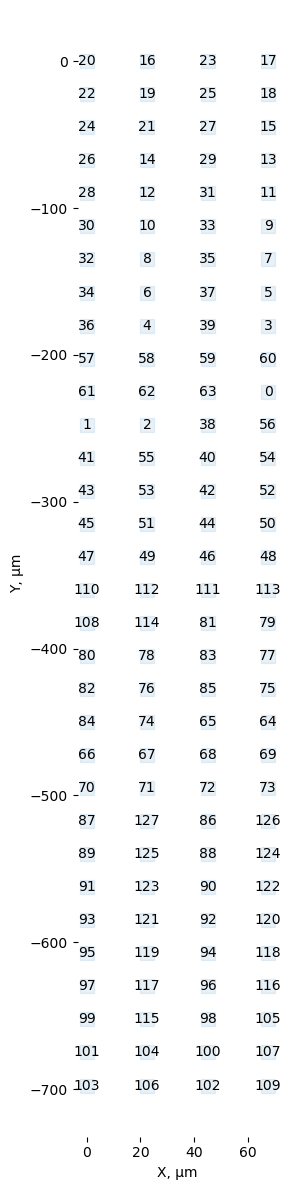

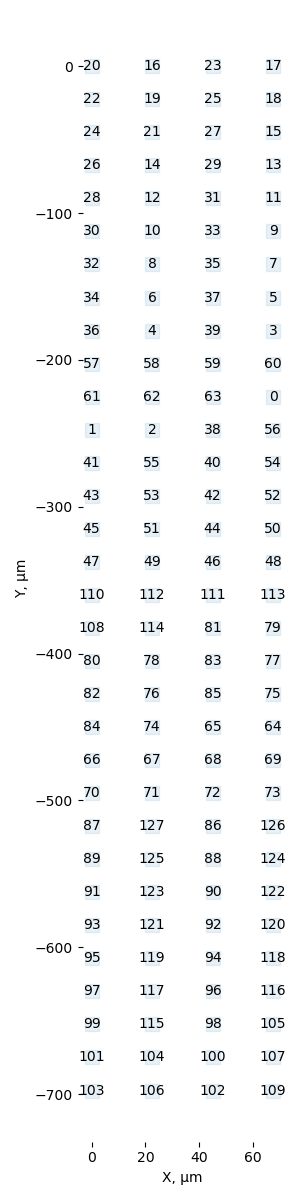

In [ ]:
plt.figure(figsize=(3,12))
plt.plot(*(df_probe.values.T[::]), 's', ms=10, alpha=0.1)
for (ch, (x,y)) in df_probe.iterrows():
    plt.text(x,y, ch, ha='center', va='center')
plt.box(False)
plt.xlabel('X, µm')
plt.ylabel('Y, µm')
plt.tight_layout()
display(plt.gcf())

# From SOFTWARE.docx file

In [ ]:
sfreq = 30000 #Sampling_frequency (Hz) = 30 000 
Probe_numChannels = 128
Probe_dtype = np.uint16
Probe_voltage_step_size = 0.195e-6
Probe_y_digitization = 32768
Juxta_numChannels = 8
Juxta_dtype = np.uint16
Juxta_ADC_used_channel = 0
Juxta_Gain = 100
Juxta_y_digitization=65536
Juxta_y_range=10
distance_min_um = 29 #distance_min (µm) = 29
Probe_closest_electrode = 99
neuroseeker_px_size_um = 22.5 

In [ ]:
# 2015_09_03_Cell9.0

# Load data from bin files into a matrix of n channels x m samples 
def loadRawData(filename,numChannels,dtype):
    fdata = np.fromfile(filename, dtype=dtype)
    assert(len(fdata)%numChannels == 0), 'improper channel number'
    numsamples = len(fdata) // numChannels
    
    data = np.reshape(fdata,(numsamples,numChannels))
    return (np.transpose(data))

## Read Juxta record

In [ ]:
###Open ADC file ###
juxta = loadRawData('adc2015-09-03T21_18_47.bin',
                    numChannels = Juxta_numChannels, 
                    dtype = Juxta_dtype)[Juxta_ADC_used_channel, :].astype('float64')
juxta *= (Juxta_y_range /( Juxta_y_digitization * Juxta_Gain)) * 1e6
juxta_times = np.arange(len(juxta))/sfreq

## Whole record view

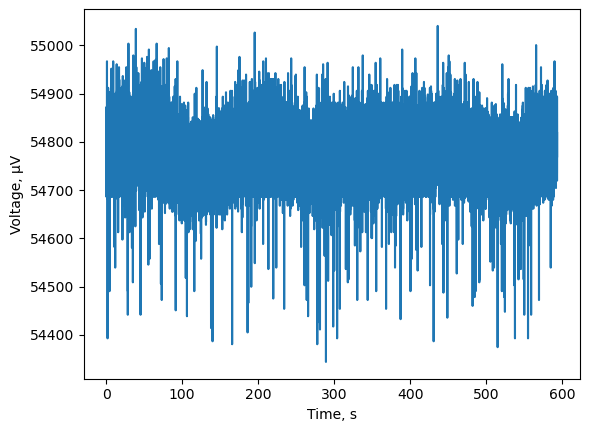

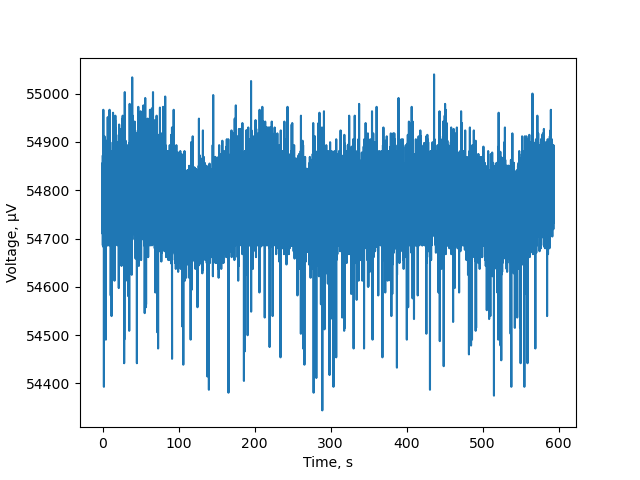

In [ ]:
plt.figure()
plt.plot(juxta_times[::300], juxta[::300])
plt.xlabel('Time, s')
plt.ylabel('Voltage, µV')

display(plt.gcf())

## Chunk view

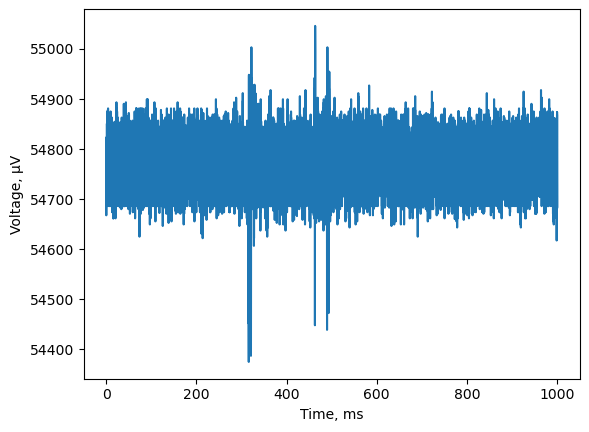

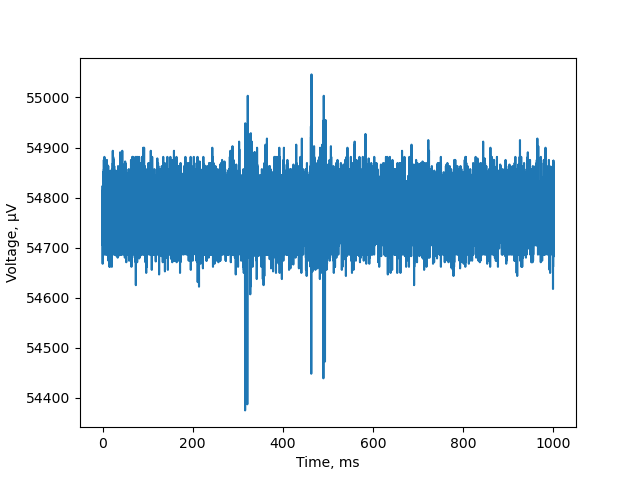

In [ ]:
plt.figure()
plt.plot(juxta_times[juxta_times<1]*1000, juxta[juxta_times<1])
plt.xlabel('Time, ms')
plt.ylabel('Voltage, µV')

display(plt.gcf())

# Probe readings

In [12]:
%%time

### Open Amplifier file ###
extra = loadRawData('amplifier2015-09-03T21_18_47-001.bin', 
                    numChannels = Probe_numChannels, 
                    dtype = Probe_dtype).astype('float64')
extra -= Probe_y_digitization
extra *= Probe_voltage_step_size

CPU times: user 17.7 s, sys: 1min 7s, total: 1min 25s
Wall time: 2min 11s


In [13]:
assert(juxta.shape[0] == extra.shape[-1])
print('We\'re lucky as hell!!!!!!!')

times = juxta_times

We're lucky as hell!!!!!!!


## Multimodal visualization

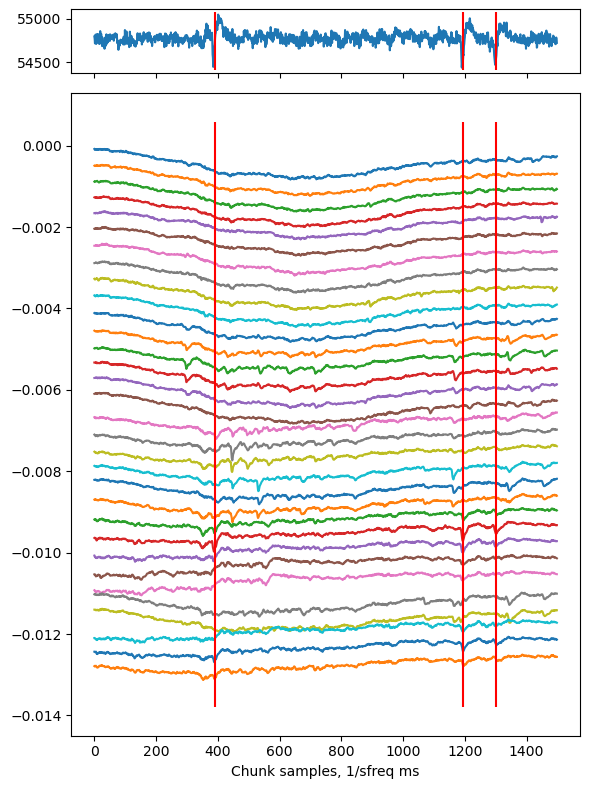

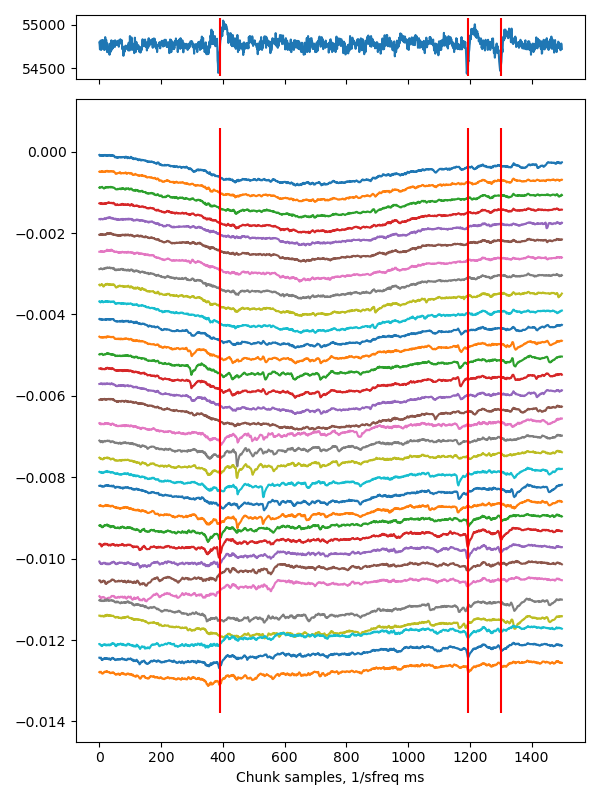

In [14]:
time_mask = ((times>0.45) * (times<0.5))

fig, axx = plt.subplots(2,1, sharex=True, gridspec_kw={'height_ratios': (1, 10)}, figsize=(6,8))
plt.sca(axx[0])
plt.plot(juxta[time_mask])
plt.vlines([391, 1194, 1301], *plt.ylim(), color='r')

plt.sca(axx[1])
plt.plot(extra[::4, time_mask].T - np.arange(Probe_numChannels)[::4]*1e-4);
plt.vlines([391, 1194, 1301], *plt.ylim(), color='r')

plt.xlabel('Chunk samples, 1/sfreq ms')

plt.tight_layout()

display(plt.gcf())

# Forward solution: ground truth spike -> extracellular spike

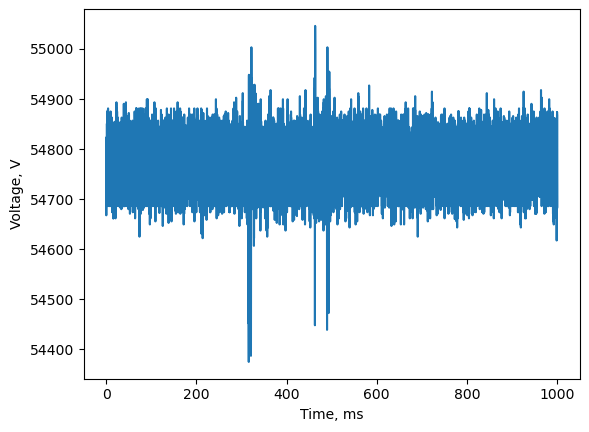

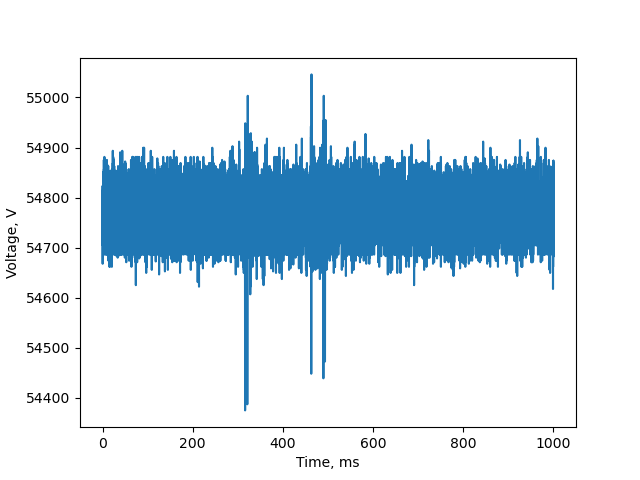

In [15]:
plt.figure()
plt.plot(juxta_times[juxta_times<1]*1000, juxta[juxta_times<1])
plt.xlabel('Time, ms')
plt.ylabel('Voltage, V')

display(plt.gcf())

## How to find the proper threshold line? Statistics!

n-sigma threshold approach:

$t = \frac{x - <x>}{\sigma(x)}$ - t-statistics  

$t < n$  for negative deviation  
$t > n$  for positive deviation  
$abs(t) > n$  for any deviation

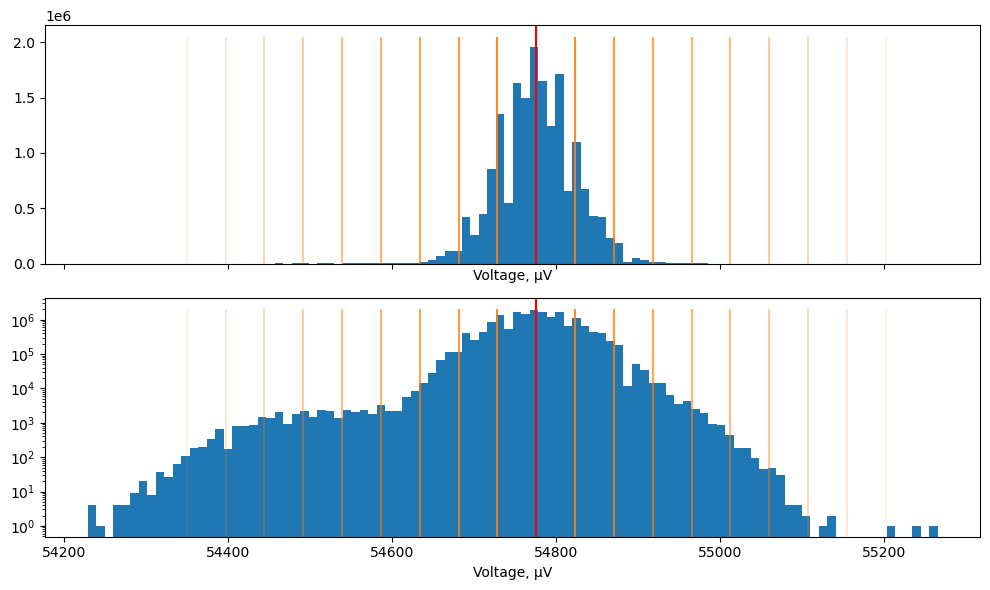

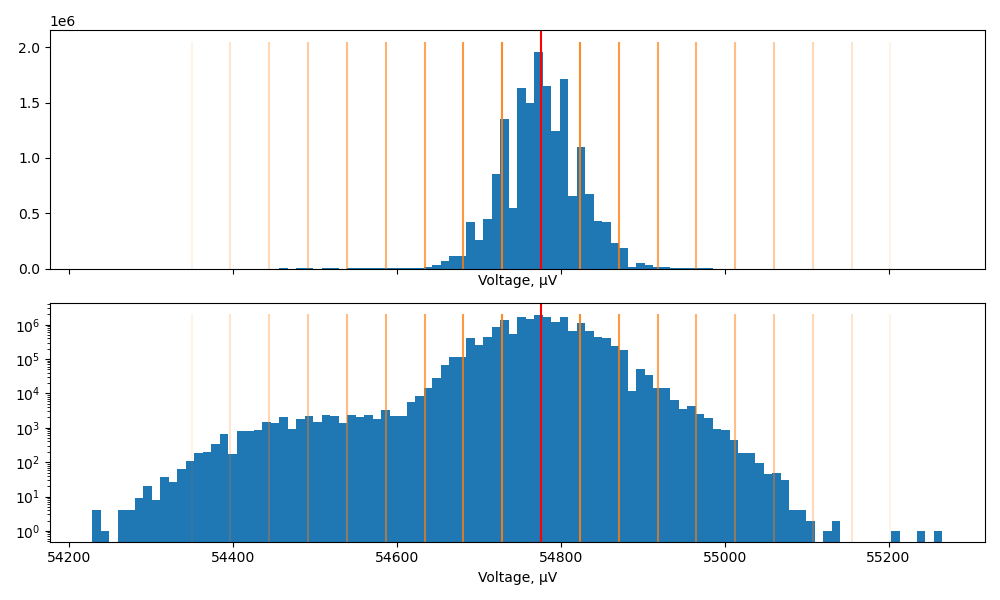

In [16]:
juxta_mean = juxta.mean()
juxta_std = juxta.std()

fig, axx = plt.subplots(2,1, sharex=True, figsize=(10,6))
plt.sca(axx[0])
plt.hist(juxta, bins=100);
plt.axvline(juxta_mean, color='r')

yl = plt.ylim()
for s in np.arange(1,10):
    plt.vlines([-s*juxta_std + juxta_mean, s*juxta_std + juxta_mean], *yl, color='C1', alpha=1-s/10)
plt.xlabel('Voltage, µV')


plt.sca(axx[1])
plt.hist(juxta, bins=100);
plt.axvline(juxta_mean, color='r')

yl = plt.ylim()
for s in np.arange(1,10):
    plt.vlines([-s*juxta_std + juxta_mean, s*juxta_std + juxta_mean], *yl, color='C1', alpha=1-s/10)
plt.xlabel('Voltage, µV')
plt.yscale('log')

plt.tight_layout()

display(plt.gcf())

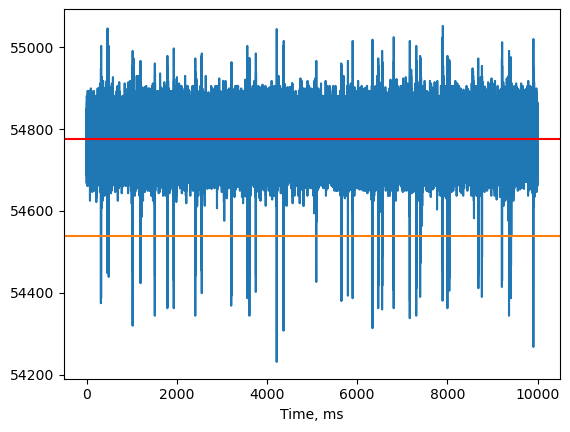

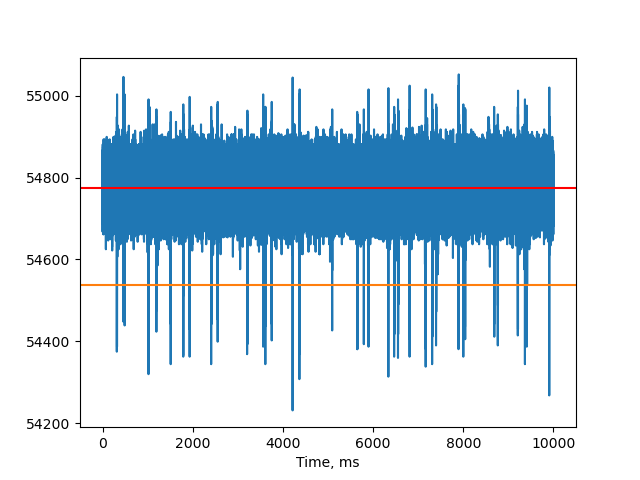

In [17]:
n_sigmas = 5

plt.figure()
plt.plot(juxta_times[juxta_times<10]*1000, juxta[juxta_times<10])
plt.axhline(juxta_mean, color='r')
plt.axhline(juxta_mean - juxta_std*n_sigmas, color='C1')
plt.xlabel('Time, ms')

display(plt.gcf())

## Look closer - We need preprocessing!!!

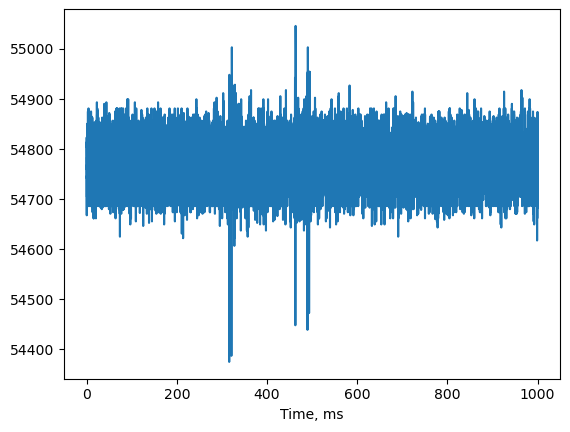

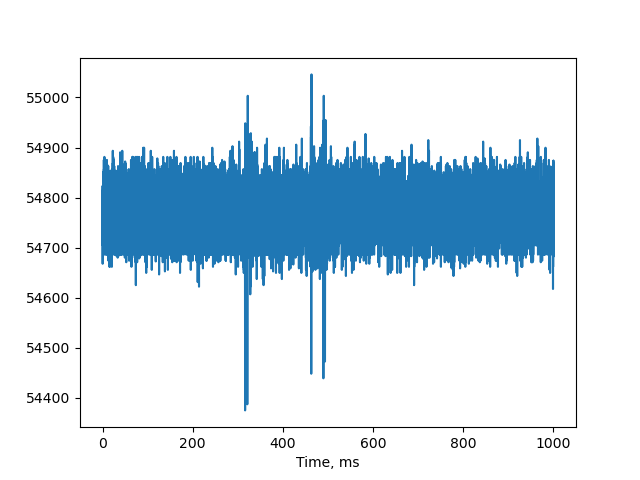

In [18]:
plt.figure()
plt.plot(juxta_times[juxta_times<1]*1000, juxta[juxta_times<1])
plt.xlabel('Time, ms')

display(plt.gcf())

In [19]:
import mne

In [20]:
%%time
psd,freqs = mne.time_frequency.psd_array_welch(juxta, sfreq, fmin=1, fmax=sfreq/2, n_fft=1024)

Effective window size : 0.034 (s)
CPU times: user 630 ms, sys: 313 ms, total: 943 ms
Wall time: 1.2 s


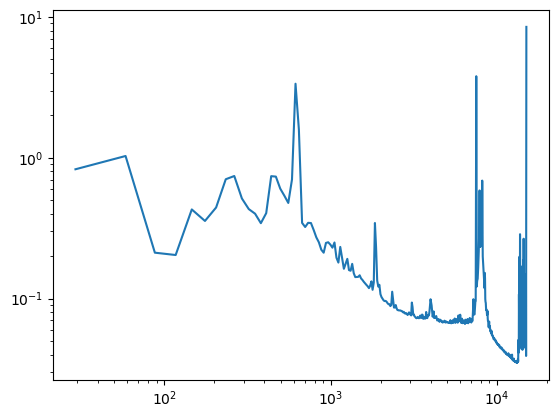

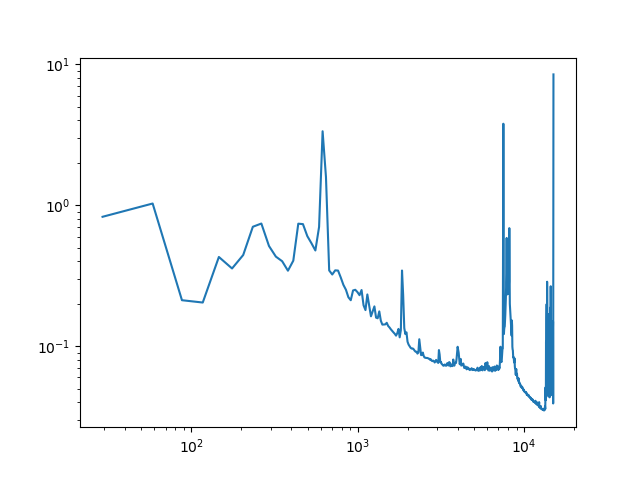

In [21]:
plt.figure()
plt.plot(freqs, psd)
plt.xscale('log')
plt.yscale('log')

display(plt.gcf())

Setting up band-pass filter from 1e+02 - 4.5e+03 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 100.00
- Lower transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 87.50 Hz)
- Upper passband edge: 4500.00 Hz
- Upper transition bandwidth: 1125.00 Hz (-6 dB cutoff frequency: 5062.50 Hz)
- Filter length: 3961 samples (0.132 sec)



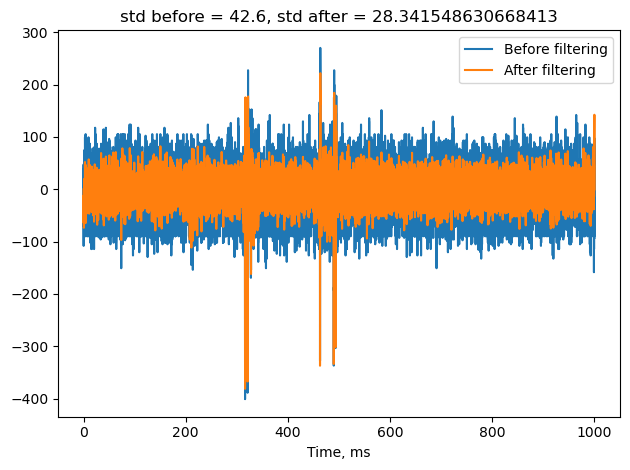

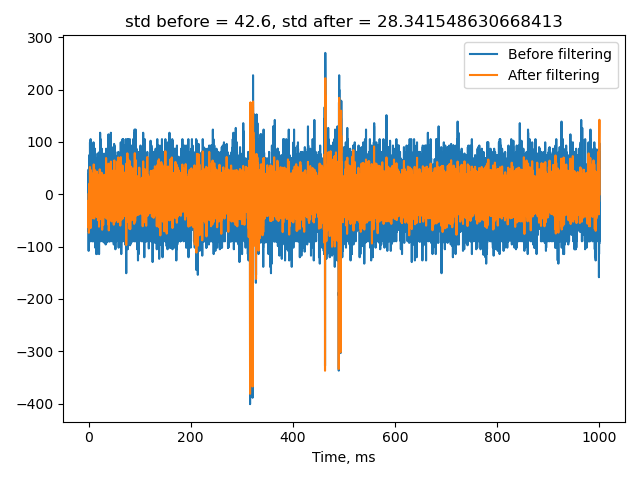

In [22]:
trace = juxta[juxta_times<1].copy()
trace_times = juxta_times[juxta_times<1]*1000

trace_std = trace.std()

plt.figure()
plt.plot(trace_times, trace-juxta_mean)

mne.filter.filter_data(trace, sfreq, l_freq=100, h_freq=4500, copy=False)

plt.plot(trace_times, trace)

plt.xlabel('Time, ms')

plt.legend(['Before filtering', 'After filtering'])

plt.title(f'std before = {trace_std:.1f}, std after = {trace.std()}')

plt.tight_layout()

display(plt.gcf())

Setting up band-pass filter from 1e+02 - 4.5e+03 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 100.00
- Lower transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 87.50 Hz)
- Upper passband edge: 4500.00 Hz
- Upper transition bandwidth: 1125.00 Hz (-6 dB cutoff frequency: 5062.50 Hz)
- Filter length: 3961 samples (0.132 sec)



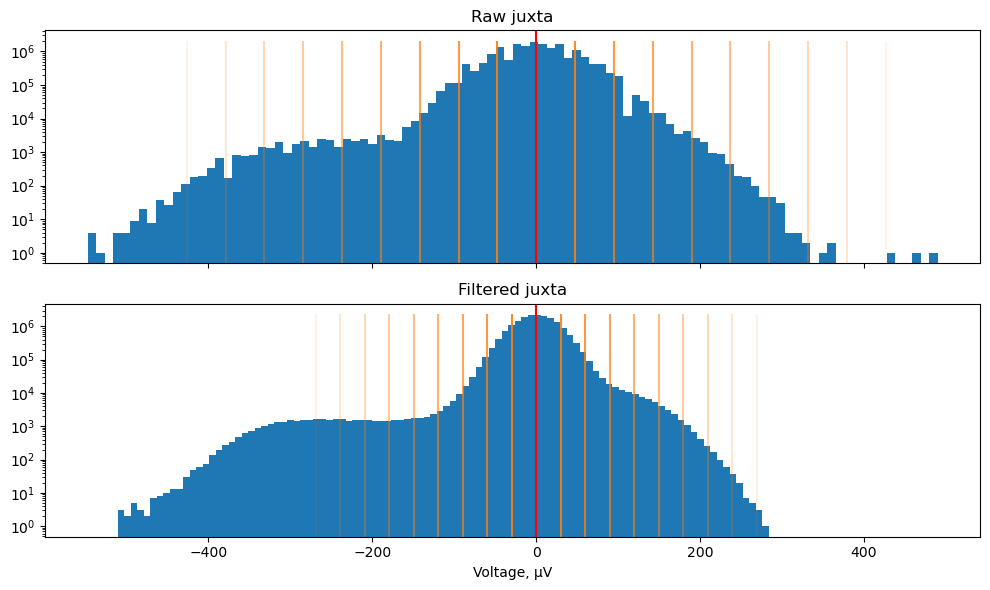

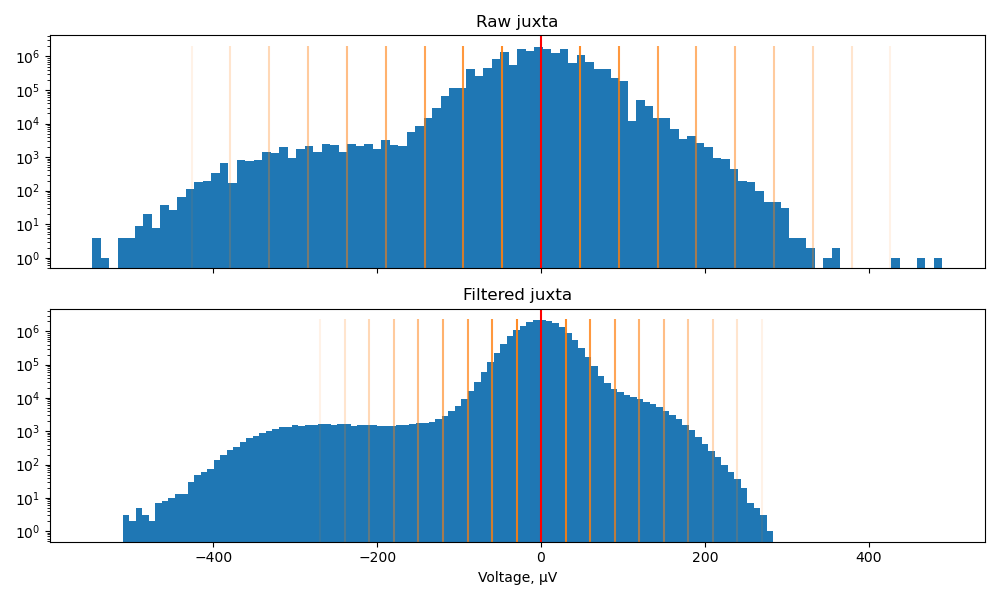

In [23]:
juxta_filt = mne.filter.filter_data(juxta, sfreq, l_freq=100, h_freq=4500)

juxta_mean = juxta.mean()
juxta_std = juxta.std()

juxta_filt_mean = juxta_filt.mean()
juxta_filt_std = juxta_filt.std()

fig, axx = plt.subplots(2,1, sharex=True, figsize=(10,6))
plt.sca(axx[0])
plt.hist(juxta-juxta_mean, bins=100);
plt.axvline(0, color='r')

yl = plt.ylim()
for s in np.arange(1,10):
    plt.vlines([-s*juxta_std, s*juxta_std], *yl, color='C1', alpha=1-s/10)
plt.yscale('log')
plt.title('Raw juxta')

plt.sca(axx[1])
plt.hist(juxta_filt, bins=100);
plt.axvline(juxta_filt_mean, color='r')

yl = plt.ylim()
for s in np.arange(1,10):
    plt.vlines([-s*juxta_filt_std + juxta_filt_mean, s*juxta_filt_std + juxta_filt_mean], *yl, color='C1', alpha=1-s/10)
plt.xlabel('Voltage, µV')
plt.yscale('log')
plt.title('Filtered juxta')

plt.tight_layout()

display(plt.gcf())

## Then we will work with filtered trace

## Now — segmentation

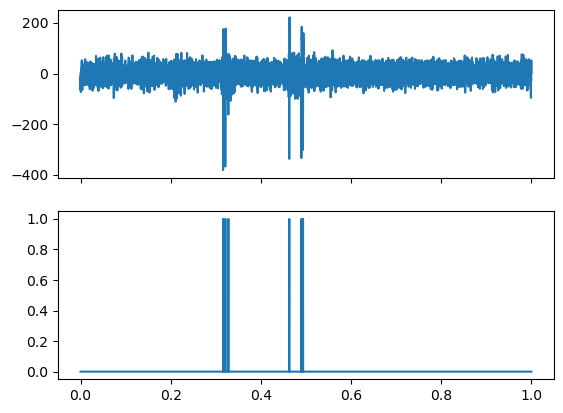

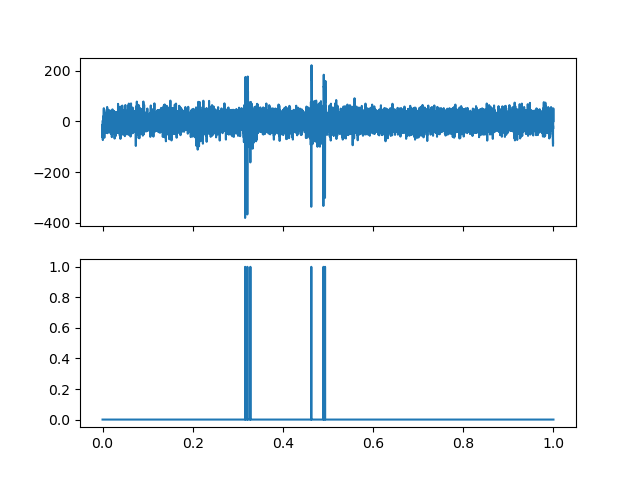

In [24]:
mask = juxta_filt < -(juxta_filt_std * 5)

fig, axx = plt.subplots(2,1, sharex=True)
plt.sca(axx[0])
plt.plot(times[times<1], juxta_filt[times<1])

plt.sca(axx[1])
plt.plot(times[times<1], mask[times<1])

display(plt.gcf())

## Mask correction with binary closing

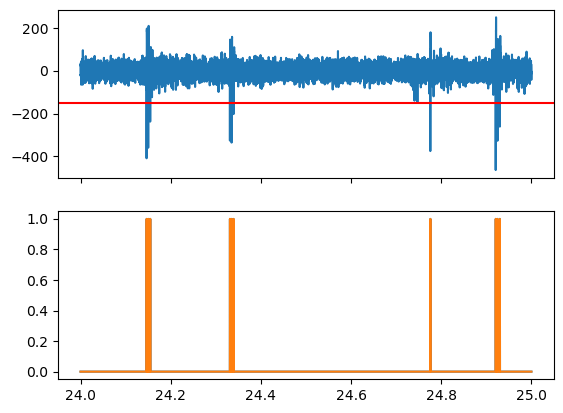

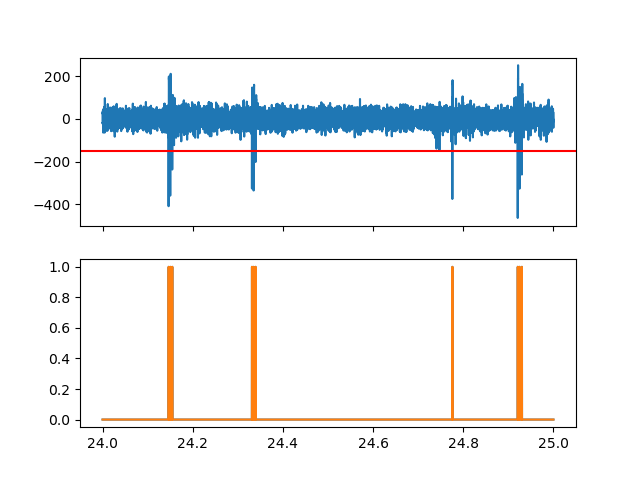

In [25]:
from scipy.ndimage import binary_closing

juxta_thresh = -(juxta_filt_std * 5)

mask = juxta_filt < juxta_thresh

time_mask = (times>24) & (times<25)

fig, axx = plt.subplots(2,1, sharex=True)
plt.sca(axx[0])
plt.plot(times[time_mask], juxta_filt[time_mask])
plt.axhline(juxta_thresh, color='r')

plt.sca(axx[1])
plt.plot(times[time_mask], mask[time_mask])

mask_close = binary_closing(mask, np.ones(int(500e-6 * sfreq)))

plt.sca(axx[1])
plt.plot(times[time_mask], mask_close[time_mask])


display(plt.gcf())

## Segmentation — finding edges

In [26]:
assert(not mask_close[0])
assert(not mask_close[-1])

In [27]:
np.where(np.diff(mask_close.astype(int), prepend=0)>0), np.where(np.diff(mask_close.astype(int), prepend=0)<0)

((array([    9481,     9629,     9833, ..., 17788451, 17788556, 17789748]),),
 (array([    9489,     9637,     9837, ..., 17788459, 17788564, 17789756]),))

In [28]:
df_regions = pd.DataFrame({'Onset' : np.where(np.diff(mask_close.astype(int), prepend=0) > 0)[0] - 1, 
                           'Offset': np.where(np.diff(mask_close.astype(int), prepend=0) < 0)[0]   }).astype(int)
df_regions

,Onset,Offset
0,9480,9489
1,9628,9637
2,9832,9837
3,13883,13890
4,14689,14698
...,...,...
5017,17784490,17784500
5018,17784612,17784622
5019,17788450,17788459
5020,17788555,17788564


## Find peaks and locations

In [29]:
df_regions['Peak'] = df_regions.apply(lambda row: juxta_filt[row.Onset: row.Offset].argmin() + row.Onset, axis=1).astype(int)
df_regions

,Onset,Offset,Peak
0,9480,9489,9485
1,9628,9637,9632
2,9832,9837,9835
3,13883,13890,13886
4,14689,14698,14692
...,...,...,...
5017,17784490,17784500,17784495
5018,17784612,17784622,17784617
5019,17788450,17788459,17788455
5020,17788555,17788564,17788559


In [30]:
df_regions['Amplitude_uV'] = juxta_filt[df_regions.Peak.values]
df_regions

,Onset,Offset,Peak,Amplitude_uV
0,9480,9489,9485,-381.334085
1,9628,9637,9632,-367.402225
2,9832,9837,9835,-161.876045
3,13883,13890,13886,-337.190903
4,14689,14698,14692,-333.893542
...,...,...,...,...
5017,17784490,17784500,17784495,-351.438278
5018,17784612,17784622,17784617,-294.095954
5019,17788450,17788459,17788455,-390.950773
5020,17788555,17788564,17788559,-291.468410


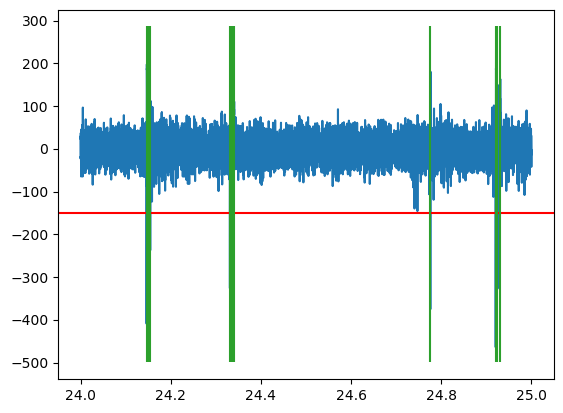

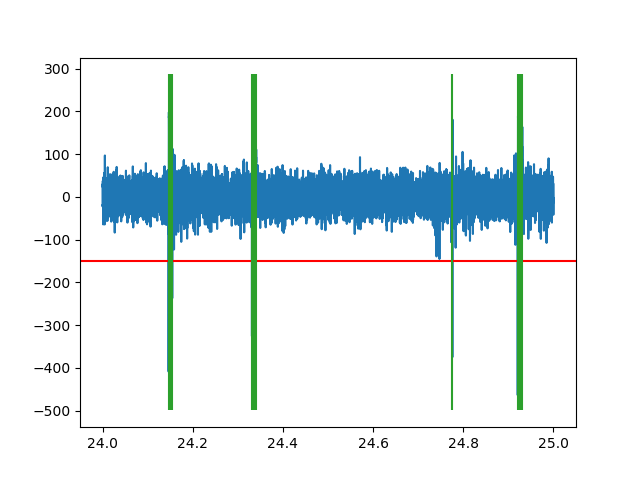

In [31]:
from scipy.ndimage import binary_closing

juxta_thresh = -(juxta_filt_std * 5)

mask = juxta_filt < juxta_thresh
mask_close = binary_closing(mask, np.ones(int(500e-6 * sfreq)))

time_mask = (times>24) & (times<25)

fig, axx = plt.subplots(1,1, sharex=True)

plt.plot(times[time_mask], juxta_filt[time_mask])
plt.axhline(juxta_thresh, color='r')
xl = plt.xlim()

plt.vlines(times[df_regions.Peak.values], *plt.ylim(), color='C2')

plt.xlim(xl )

display(plt.gcf())

# Collecting samples of juxtacellular spikes

In [32]:
window_ms = 5
window_half_ts = int(window_ms * sfreq/1000)//2 + 1
window_times_us = np.arange(-window_half_ts, window_half_ts, 1)*1e6/sfreq

juxta_samples = np.stack([juxta_filt[int(row.Peak) - window_half_ts: int(row.Peak) + window_half_ts] for irow, row in df_regions.iterrows()], axis=0)
juxta_samples.shape

(5022, 152)

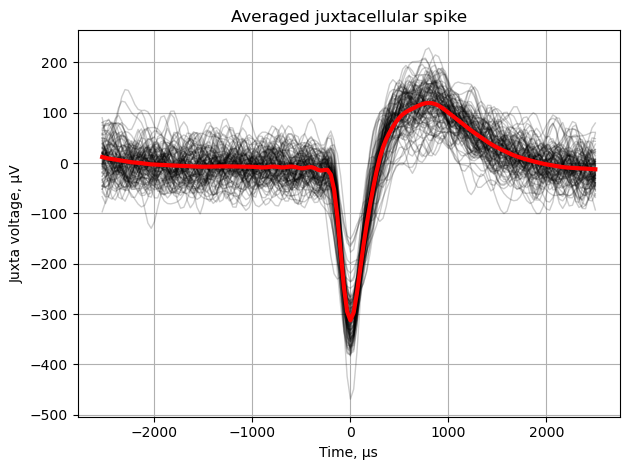

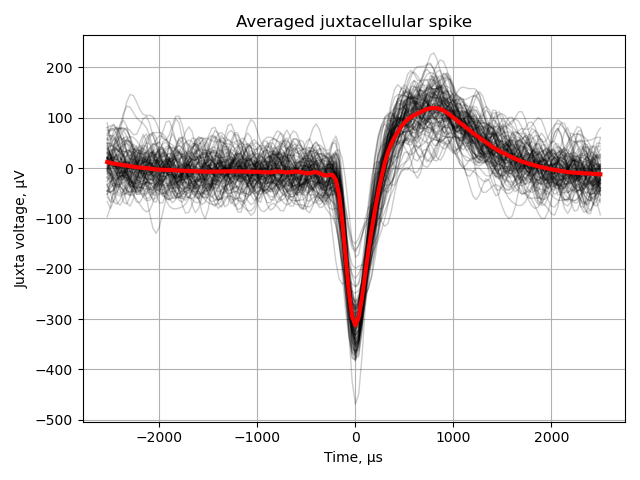

In [33]:
juxta_samples_mean = juxta_samples.mean(0)

plt.figure()
plt.plot(window_times_us, juxta_samples[::50].T, color='k', alpha=0.2, lw=1)
plt.plot(window_times_us, juxta_samples_mean, color='r', lw=3)
plt.title('Averaged juxtacellular spike')

plt.xlabel('Time, µs')
plt.ylabel('Juxta voltage, µV')
plt.grid(True)

plt.tight_layout()

display(plt.gcf())

### Some spike statistics

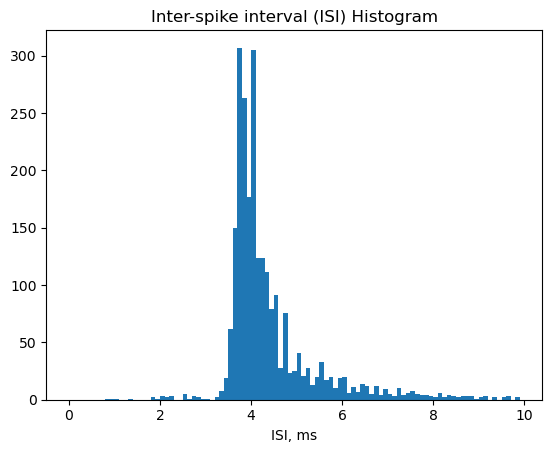

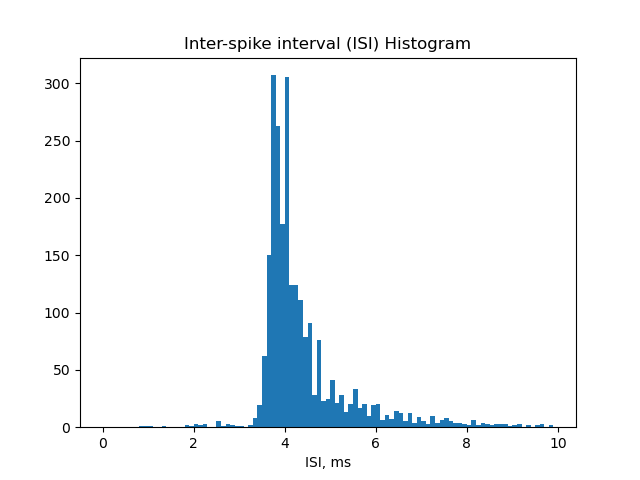

In [34]:
plt.figure()
plt.hist(np.diff(df_regions.Peak.values)*1000/sfreq, bins=np.arange(0, 10, 0.1));
plt.title('Inter-spike interval (ISI) Histogram')
plt.xlabel('ISI, ms')

display(plt.gcf())

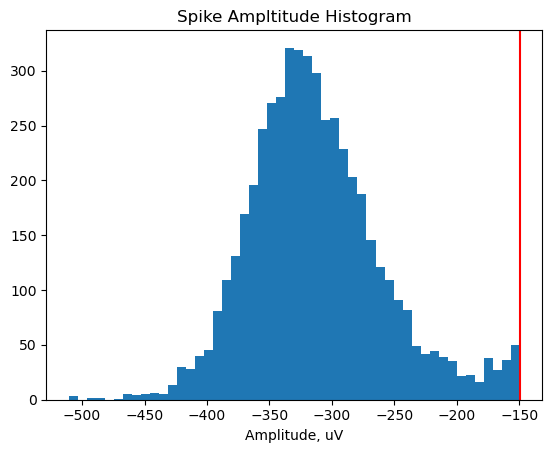

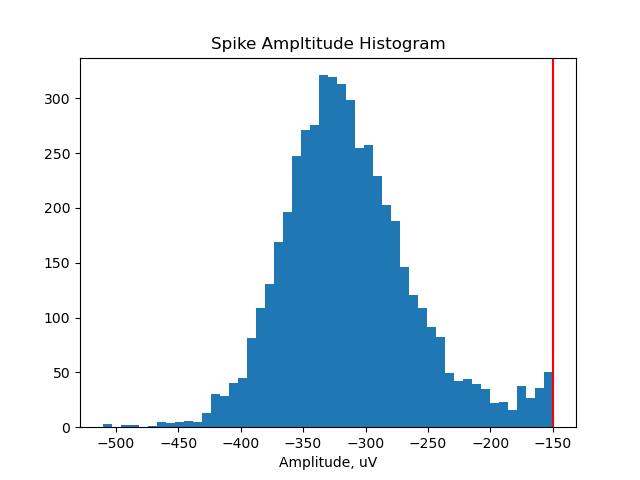

In [35]:
plt.figure()
plt.hist((df_regions.Amplitude_uV), bins=50);
plt.title('Spike Ampltitude Histogram')
plt.xlabel('Amplitude, uV')
plt.axvline(juxta_thresh, color='r')

display(plt.gcf())

# Collecting samples of extracellular spikes

In [36]:
%%time


from tqdm.autonotebook import tqdm
extra_samples = np.stack([extra[:, int(row.Peak) - window_half_ts: int(row.Peak) + window_half_ts] 
                          for irow, row in tqdm(df_regions.iterrows(), total=len(df_regions))], 
                        axis=0)
    

<timed exec>:1: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


  0%|          | 0/5022 [00:00<?, ?it/s]

CPU times: user 655 ms, sys: 1.37 s, total: 2.02 s
Wall time: 3.76 s


In [37]:
extra_samples.shape

(5022, 128, 152)

## Postprocess

In [38]:
%%time

# Remove drifts and shifts

extra_samples_detrend = mne.filter.detrend(extra_samples)

CPU times: user 9.94 s, sys: 3.79 s, total: 13.7 s
Wall time: 7.36 s


In [49]:
extra_samples_mean = extra_samples.mean(0)
extra_samples_mean = mne.filter.detrend(extra_samples_mean)
extra_samples_mean.shape

(128, 152)

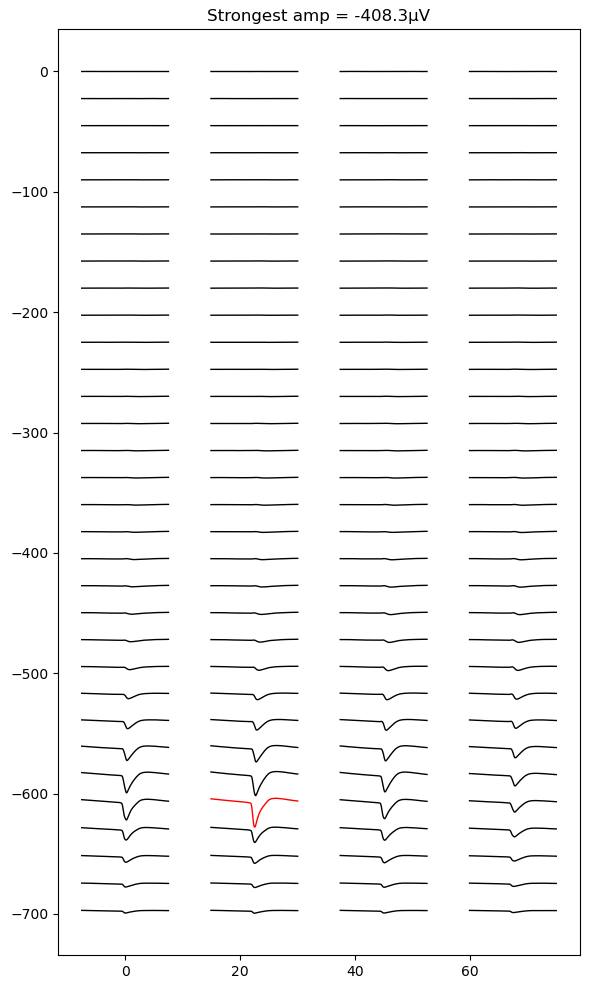

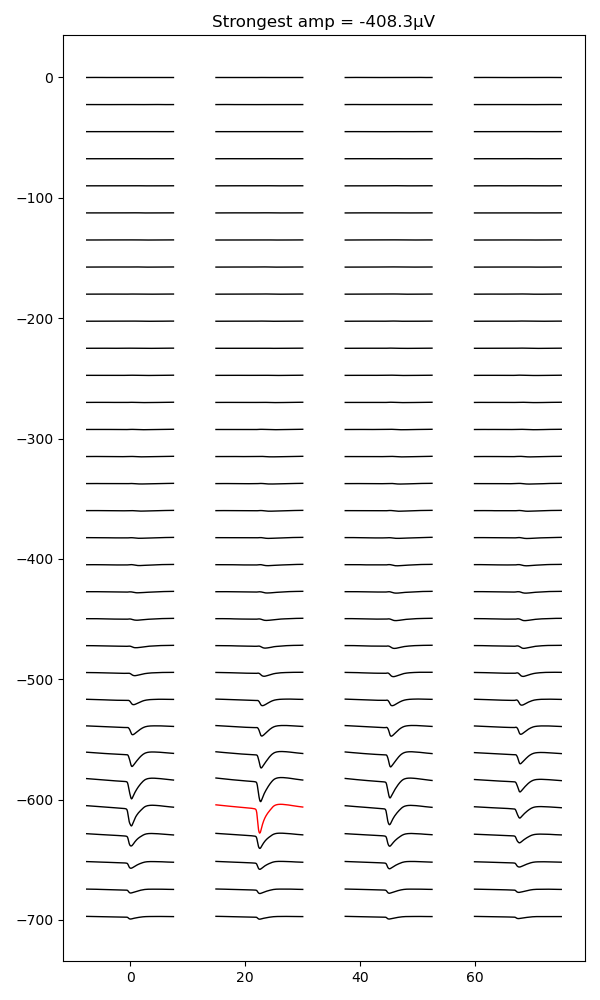

In [50]:

n_strongest_channel = extra_samples_mean[:, window_half_ts].argmin()
strongest_amplitude = extra_samples_mean[n_strongest_channel, window_half_ts]

plt.figure(figsize=(6,10))
time_scale = 3e-3
voltage_scale = 5e4

for irow, row in df_probe.iterrows():
    if irow == n_strongest_channel:
        c = 'r'
    else:
        c = 'k'
    plt.plot(window_times_us*time_scale + row.x,  
             extra_samples_mean[irow]*voltage_scale + row.y, 
             color=c, 
             lw=1)
    
plt.title(f'Strongest amp = {strongest_amplitude*1e6:.1f}µV')
plt.tight_layout()


display(plt.gcf())

In [51]:
extra_samples_mean.min(-1).argmin()

119

## Extracellular Spike Analysis

## Elephant package

https://elephant.readthedocs.io/en/latest/reference/current_source_density.html



In [52]:
%pip install elephant

Note: you may need to restart the kernel to use updated packages.


In [53]:
col_2_idx = df_probe.query('x == 22.5').sort_values(by='y', ascending=False).index

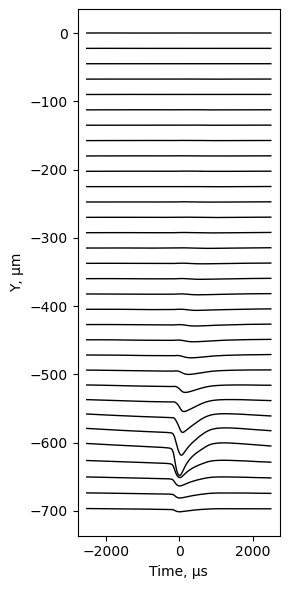

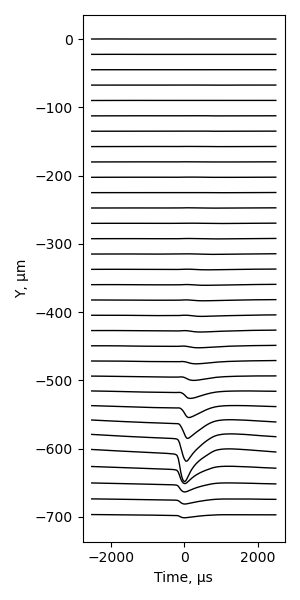

In [54]:
coords = df_probe.loc[col_2_idx, 'y']

plt.figure(figsize=(3,6))
plt.plot(window_times_us, extra_samples_mean[col_2_idx, :].T*1e5 + coords.values, 
         color='k', lw=1)

plt.xlabel('Time, µs')
plt.tight_layout()
plt.ylabel('Y, µm')
plt.tight_layout()

display(plt.gcf())

In [55]:

import elephant
import neo
import quantities as pq

analog = neo.AnalogSignal(extra_samples_mean[col_2_idx, :].T, 
                          units=pq.uV, 
                          sampling_rate=sfreq*pq.Hz)

csd = elephant.current_source_density.estimate_csd(lfp = analog, 
                                                     coordinates=df_probe.loc[col_2_idx, 'y'].values.reshape(-1,1)*pq.um, 
                                                     method='StandardCSD', process_estimate=False)

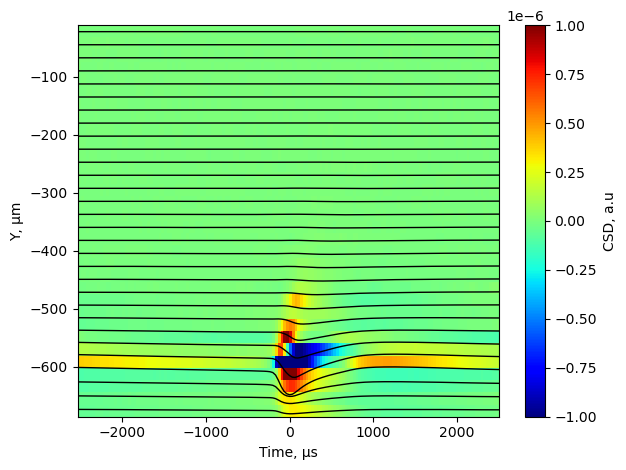

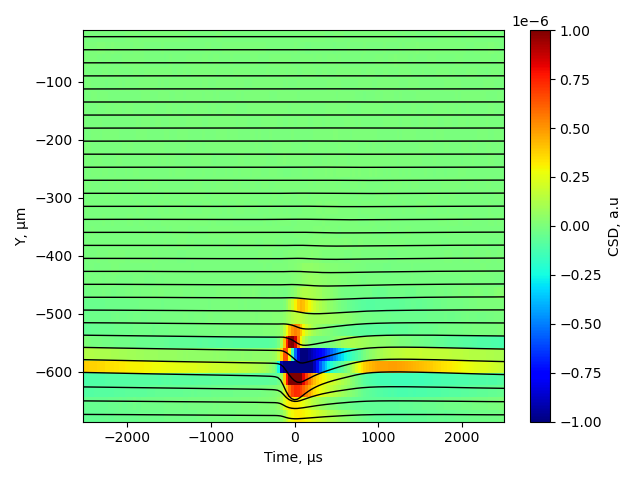

In [70]:
plt.figure()

plt.plot(window_times_us, extra_samples_mean[col_2_idx, :].T*1e5 +coords.values, 
         color='k', lw=1)

plt.imshow(csd.T, aspect='auto', 
           extent=(window_times_us[0], 
                   window_times_us[-1], 
                   coords.min()+11.25, 
                   coords.max()-11.25), 
           zorder=-1, 
           vmin=-1e-6, vmax=1e-6, cmap='jet',
           interpolation='nearest')
plt.colorbar(label='CSD, a.u')
plt.xlabel('Time, µs')
plt.ylabel('Y, µm')
plt.tight_layout()

display(plt.gcf())